In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from data.aware_raw import AwareRaw, AwareSpectrogram
from data.cats_and_dogs import Dataset

classes = [
    'Control / healthy / no pulmonary disease',
    'Asthma'
]
dataset_raw = AwareRaw("data/AWARE_DATA_LABELS_2023-12-08_1611.csv", "data/id_map.csv", "data/aware_full_1704385505.db", pickle_file="data/aware_segmented.pkl")
dataset = AwareSpectrogram(dataset_raw, target_classes=classes, age_balanced=False, output_demogr=True, output_spiro_pred=True, num_channels=3)
# dataset.save_to_pickle('data/aware_spectrogram.pkl')

class_weights = compute_class_weight(
    'balanced', 
    classes=classes, 
    y=dataset.data['Participant:']
)
print("Class Weights:")
print(class_weights)

# dataset = Dataset("data/cats_and_dogs")

# class_weights = compute_class_weight(
#     'balanced', 
#     classes=[0,1], 
#     y=dataset.data['label']
# )
# print("Class Weights:")
# print(class_weights)

0it [00:00, ?it/s]

Class Weights:
[1.3032491  0.81123596]


In [3]:
inputs, demogr, spiro, labels = dataset[0]
print(demogr)
# print(np.concatenate((demogr[1:4:2], spiro), axis=0))
print(inputs.shape)
print(inputs.dtype)

[ 14.7   0.  157.   47. ]
torch.Size([3, 50, 224, 224])
torch.float32


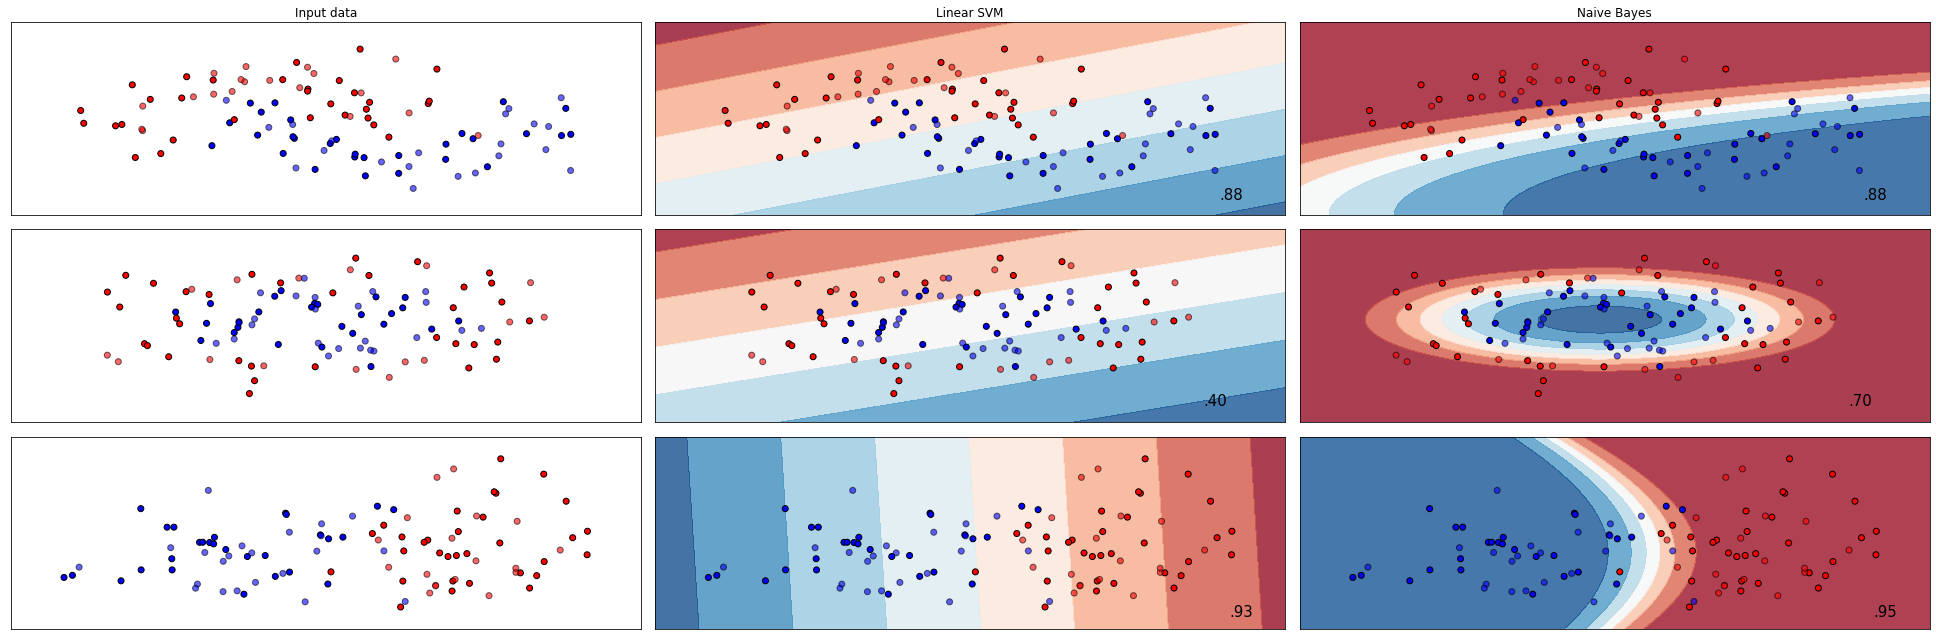

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

names = [
    # "KNN",
    "Linear SVM",
    # "RBF SVM",
    # "Logistic Regr",
    # "Decision Tree",
    # "Random Forest",
    # "MLP",
    # "AdaBoost",
    "Naive Bayes"
]

classifiers = [
    # KNeighborsClassifier(5),
    SVC(kernel="linear", C=0.025, random_state=42),
    # SVC(gamma=2, C=1, random_state=42),
    # LogisticRegression(),
    # DecisionTreeClassifier(max_depth=5, random_state=42),
    # RandomForestClassifier(
    #     max_depth=5, n_estimators=10, max_features=1, random_state=42
    # ),
    # MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    # AdaBoostClassifier(algorithm="SAMME", random_state=42),
    GaussianNB()
]

X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1
)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [
    make_moons(noise=0.3, random_state=0),
    make_circles(noise=0.2, factor=0.5, random_state=1),
    linearly_separable,
]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)

        clf = make_pipeline(StandardScaler(), clf)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        DecisionBoundaryDisplay.from_estimator(
            clf, X, cmap=cm, alpha=0.8, ax=ax, eps=0.5
        )

        # Plot the training points
        ax.scatter(
            X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
        )
        # Plot the testing points
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(
            x_max - 0.3,
            y_min + 0.3,
            ("%.2f" % score).lstrip("0"),
            size=15,
            horizontalalignment="right",
        )
        i += 1

plt.tight_layout()
plt.show()

In [5]:
import pandas as pd
from sklearn.manifold import TSNE
import sklearn.metrics as M
import seaborn as sns
from data.aware_raw import KFoldSplitter

RANDOM_SEED = 4399
BATCH_SIZE = 2000

splitter = KFoldSplitter(dataset, BATCH_SIZE, random_seed=RANDOM_SEED)
df = pd.DataFrame()
output = {
    "Linear SVM": pd.DataFrame(),
    "Naive Bayes": pd.DataFrame()
}
cols = [
    'Age', 'Sex', 'Height', 'Weight',
    # 'FEV1', 'FVC', 'FEV1/FVC', 'FEF2575',
    'Diagnosis', 'Prediction'
]
for split_idx, (train_loader, test_loader) in enumerate(splitter):
    for batch_idx, (inputs, demogr, spiro, labels) in enumerate(train_loader):
        # X_train = np.concatenate((demogr, spiro), axis=1)
        X_train = demogr
        y_train = labels
    for batch_idx, (inputs, demogr, spiro, labels) in enumerate(test_loader):
        # X_test = np.concatenate((demogr, spiro), axis=1)
        X_test = demogr
        y_test = labels

#     tsne = TSNE(n_components=2, verbose=0, n_iter=300)
#     tsne_results = tsne.fit_transform(X_train)
#     results = {'tsne-2d-one': tsne_results[:,0],
#                'tsne-2d-two': tsne_results[:,1],
#                'y': y_train}

#     plt.figure(figsize=(4, 4))
#     x_min, x_max = tsne_results[:,0].min() - 0.5, tsne_results[:,0].max() + 0.5
#     y_min, y_max = tsne_results[:,1].min() - 0.5, tsne_results[:,1].max() + 0.5

#     # just plot the dataset first
#     cm = plt.cm.RdBu
#     cm_bright = ListedColormap(["#FF0000", "#0000FF"])
#     if ds_cnt == 0:
#         plt.title("Input data")
#     # Plot the training points
#     tsne_results = tsne.fit_transform(X_train)
#     results = {'tsne-2d-one': tsne_results[:,0],
#                'tsne-2d-two': tsne_results[:,1],
#                'y': y_train}
#     plt.scatter(tsne_results[:,0], tsne_results[:,1], c=y_train, cmap=cm_bright, edgecolors="k")
#     # Plot the testing points
#     tsne_results = tsne.fit_transform(X_test)
#     results = {'tsne-2d-one': tsne_results[:,0],
#                'tsne-2d-two': tsne_results[:,1],
#                'y': y_test}
#     plt.scatter(
#         tsne_results[:,0], tsne_results[:,1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
#     )
#     plt.xlim(x_min, x_max)
#     plt.ylim(y_min, y_max)
#     plt.show()

    # iterate over classifiers
    s = {}
    for name, clf in zip(names, classifiers):
        clf = make_pipeline(StandardScaler(), clf)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        bal_acc = M.balanced_accuracy_score(y_test, y_pred)
        s[name] = bal_acc
        out = np.concatenate([X_test, np.expand_dims(y_test,axis=1), np.expand_dims(y_pred,axis=1)], axis=1)
        out = pd.DataFrame(out, columns=cols)
        output[name] = pd.concat([output[name], out], axis=0)

    s = pd.Series(s)
    df = pd.concat([df, s.to_frame().T])
df = df.reset_index(drop=True)
df_avg = df.mean(axis=0).to_frame().T
df_avg.index = ['Avg']
display(pd.concat((df, df_avg)))

,Linear SVM,Naive Bayes
0,0.614731,0.635728
1,0.822477,0.849073
2,0.661855,0.665057
3,0.632517,0.739365
4,0.691322,0.743210
Avg,0.684580,0.726487


247 307
80 810
Sens: 0.9101123595505618
Spec: 0.44584837545126355
BalAcc: 0.6779803675009126


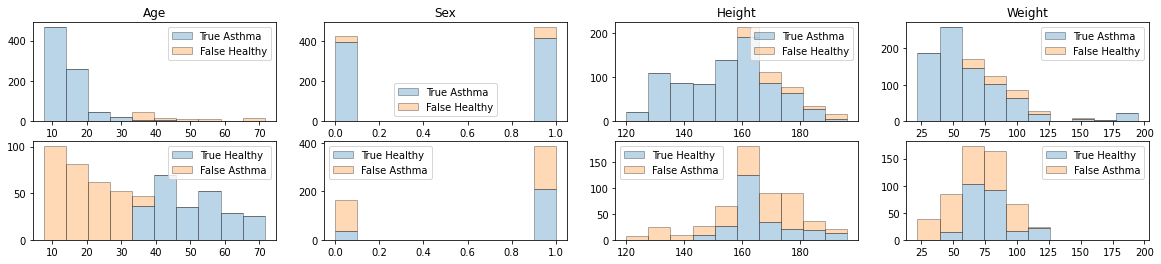

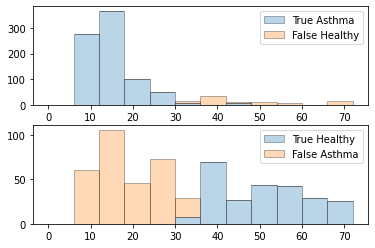

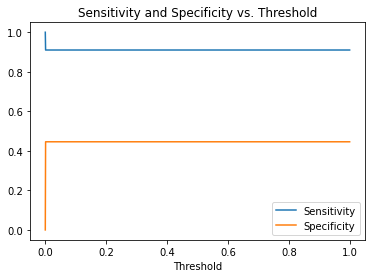

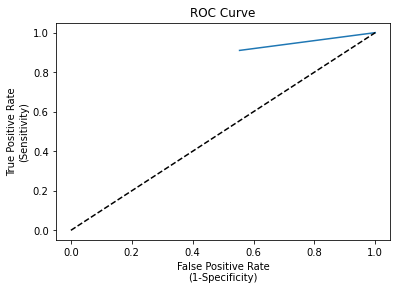

In [6]:
meta = output["Linear SVM"].reset_index(drop=True)

idx_tp = (meta['Diagnosis']==1) & (meta['Prediction']>=0.5)
tp = idx_tp.sum()
idx_fp = (meta['Diagnosis']==0) & (meta['Prediction']>=0.5)
fp = idx_fp.sum()
idx_tn = (meta['Diagnosis']==0) & (meta['Prediction']<0.5)
tn = idx_tn.sum()
idx_fn = (meta['Diagnosis']==1) & (meta['Prediction']<0.5)
fn = idx_fn.sum()
print(tn, fp)
print(fn, tp)

sens = tp/(tp+fn)
spec = tn/(fp+tn)
print('Sens:', sens)
print('Spec:', spec)
print('BalAcc:', (sens+spec)/2)

plt.figure(figsize=(20,4))
plt.subplot(2,4,1)
plt.hist(pd.concat([meta['Age'][idx_tp], meta['Age'][idx_fn]], axis=1), range=(meta['Age'].min(),meta['Age'].max()), alpha = 0.3, stacked=True, edgecolor='k', linewidth=1)
plt.legend(['True Asthma', 'False Healthy'])
plt.title('Age')
plt.subplot(2,4,5)
plt.hist(pd.concat([meta['Age'][idx_tn], meta['Age'][idx_fp]], axis=1), range=(meta['Age'].min(),meta['Age'].max()), alpha = 0.3, stacked=True, edgecolor='k', linewidth=1)
plt.legend(['True Healthy', 'False Asthma'])
plt.subplot(2,4,2)
plt.hist(pd.concat([meta['Sex'][idx_tp], meta['Sex'][idx_fn]], axis=1), range=(meta['Sex'].min(),meta['Sex'].max()), alpha = 0.3, stacked=True, edgecolor='k', linewidth=1)
plt.legend(['True Asthma', 'False Healthy'])
plt.title('Sex')
plt.subplot(2,4,6)
plt.hist(pd.concat([meta['Sex'][idx_tn], meta['Sex'][idx_fp]], axis=1), range=(meta['Sex'].min(),meta['Sex'].max()), alpha = 0.3, stacked=True, edgecolor='k', linewidth=1)
plt.legend(['True Healthy', 'False Asthma'])
plt.subplot(2,4,3)
plt.hist(pd.concat([meta['Height'][idx_tp], meta['Height'][idx_fn]], axis=1), range=(meta['Height'].min(),meta['Height'].max()), alpha = 0.3, stacked=True, edgecolor='k', linewidth=1)
plt.legend(['True Asthma', 'False Healthy'])
plt.title('Height')
plt.subplot(2,4,7)
plt.hist(pd.concat([meta['Height'][idx_tn], meta['Height'][idx_fp]], axis=1), range=(meta['Height'].min(),meta['Height'].max()), alpha = 0.3, stacked=True, edgecolor='k', linewidth=1)
plt.legend(['True Healthy', 'False Asthma'])
plt.subplot(2,4,4)
plt.hist(pd.concat([meta['Weight'][idx_tp], meta['Weight'][idx_fn]], axis=1), range=(meta['Weight'].min(),meta['Weight'].max()), alpha = 0.3, stacked=True, edgecolor='k', linewidth=1)
plt.legend(['True Asthma', 'False Healthy'])
plt.title('Weight')
plt.subplot(2,4,8)
plt.hist(pd.concat([meta['Weight'][idx_tn], meta['Weight'][idx_fp]], axis=1), range=(meta['Weight'].min(),meta['Weight'].max()), alpha = 0.3, stacked=True, edgecolor='k', linewidth=1)
plt.legend(['True Healthy', 'False Asthma'])
plt.show()

plt.figure(figsize=(6,4))
plt.subplot(2,1,1)
plt.hist(pd.concat([meta['Age'][idx_tp], meta['Age'][idx_fn]], axis=1), bins=list(range(0, 78, 6)), alpha = 0.3, stacked=True, edgecolor='k', linewidth=1)
plt.legend(['True Asthma', 'False Healthy'])
plt.subplot(2,1,2)
plt.hist(pd.concat([meta['Age'][idx_tn], meta['Age'][idx_fp]], axis=1), bins=list(range(0, 78, 6)), alpha = 0.3, stacked=True, edgecolor='k', linewidth=1)
plt.legend(['True Healthy', 'False Asthma'])
plt.show()

thre = np.zeros(1001)
sens = np.zeros(1001)
spec = np.zeros(1001)
for i in range(0,1001):
    idx_tp = (meta['Diagnosis']==1) & (meta['Prediction']>=i/1000)
    tp = idx_tp.sum()
    idx_fp = (meta['Diagnosis']==0) & (meta['Prediction']>=i/1000)
    fp = idx_fp.sum()
    idx_tn = (meta['Diagnosis']==0) & (meta['Prediction']<i/1000)
    tn = idx_tn.sum()
    idx_fn = (meta['Diagnosis']==1) & (meta['Prediction']<i/1000)
    fn = idx_fn.sum()
    thre[i] = i/1000
    sens[i] = tp/(tp+fn)
    spec[i] = tn/(fp+tn)
    
plt.figure()
plt.plot(thre, sens)
plt.plot(thre, spec)
plt.title('Sensitivity and Specificity vs. Threshold')
plt.legend(['Sensitivity', 'Specificity'])
plt.xlabel('Threshold')
plt.show()

plt.figure()
# skplt.metrics.plot_roc_curve(meta['Diagnosis'], outputs_cls)
plt.plot(1-spec, sens)
plt.plot([0,1], [0,1], '--k')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate\n(1-Specificity)')
plt.ylabel('True Positive Rate\n(Sensitivity)')
plt.show()

In [7]:
display(meta)

,Age,Sex,Height,Weight,Diagnosis,Prediction
0,10.800000,1.0,140.399994,28.200001,1.0,1.0
1,10.800000,1.0,140.399994,28.200001,1.0,1.0
2,10.800000,1.0,140.399994,28.200001,1.0,1.0
3,10.800000,1.0,140.399994,28.200001,1.0,1.0
4,10.800000,1.0,140.399994,28.200001,1.0,1.0
...,...,...,...,...,...,...
1439,15.100000,1.0,159.000000,49.000000,0.0,1.0
1440,15.100000,1.0,159.000000,49.000000,0.0,1.0
1441,17.299999,1.0,165.600006,55.799999,1.0,1.0
1442,17.299999,1.0,165.600006,55.799999,1.0,1.0
